In [ ]:
import jax
from jax.config import config
config.update("jax_enable_x64", True)

import jax.numpy as jnp
from jax.experimental.ode import odeint
from jax import value_and_grad
from jax.experimental import optimizers
from jax import jit, vmap

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

import sys, getopt

# general 
INFTY = 200
integration_pts = 100001

In [ ]:
@jit
def f_FD(eps,f_params): # (mu, beta)
    # Fermi-Dirac 
    mu = f_params[0]
    beta = f_params[1]
    
    return (1 + jnp.exp(beta*(eps-mu)))**-1

@jit
def T2(eps,T2_params): # T2_params: [gamma_L, gamma_R, eps_L, eps_R, omega] (reasonably, [0.05,0.05,0.,0.,0.005])
    # Transmission function of the serial double dot model
    gamma_L = T2_params[0]
    gamma_R = T2_params[1]
    eps_L = T2_params[2]
    eps_R = T2_params[3]
    omega = T2_params[4]
    a = eps - eps_L
    b = gamma_L/2
    c = eps - eps_R
    d = gamma_R/2

    return (((gamma_L)*(gamma_R)*(omega**2))/(((a*c - b*d - (omega**2))**2) + ((a*d + b*c)**2))) 

# vectorized versions
v_f_FD = vmap(f_FD,(0,None))
v_T2 = vmap(T2,(0,None)) 

In [ ]:
# Retarded and advanced Green's functions (f(eps)) using Dyson equation
def green (eps, input_params):  # input_params = [H, gaL, gaR, mode] and "retarded" by default
    H_s = input_params[0]
    Gamma_L = input_params[1]
    Gamma_R = input_params[2]
    mode = input_params[3]

    Hamiltonian = (eps*(jnp.identity(2))) - H_s  # Hamiltonian = e*I - H; is 2x2 matrix
    NSelf = 0.5j*(Gamma_L + Gamma_R) # Negative of self energy

    # return: resultant = (Hamiltonian + NSelf)^(-1)
    res = jnp.linalg.inv(Hamiltonian + NSelf)

    if (mode == "r"): # retarded green's function
        return res
    elif (mode == "a"): # advanced green's function
        res_prime = jnp.transpose(jnp.conjugate(res)) 
        return res_prime # Hermitian conjugate of Retarded Green's function

# vectorized Green's function over the energy axis
v_Green = vmap(green, (0, None))

In [ ]:
@jit
def ro (params2, element): 
    # params2: (mu_L, mu_R, gamma_L, gamma_R, beta_L, beta_R, eps_L, eps_R, omega)
    # "element" is the tuple input for the matrix element
    # "element" must be one of these: [(0,0),(0,1),(1,0),(1,1)]
    e_axis = jnp.linspace(-INFTY, INFTY, integration_pts) # energy axis

    # fetching parameters
    eps_L = params2[6]
    eps_R = params2[7]
    omega = params2[8]
    gamma_L = params2[2]
    gamma_R = params2[3]

    f_params_L = (params2[0], params2[4])
    f_params_R = (params2[1], params2[5])
    fL = f_FD(e_axis,f_params_L) # fermi-dirac for the left bath
    fR = f_FD(e_axis,f_params_R) # # fermi-dirac for the right bath
    
    # Building-up the Hamiltonian
    H = jnp.zeros((2,2))
    H = H.at[0,0].set(eps_L)
    H = H.at[1,1].set(eps_R)
    H = H.at[0,1].set(omega)
    H = H.at[1,0].set(omega)

    # Gamma matrices
    gaL = jnp.zeros((2,2))
    gaL = gaL.at[0,0].set(gamma_L)
    gaL_prime = jnp.reshape(gaL,(1,2,2)) 
    gaL_prime = jnp.repeat(gaL_prime, integration_pts, axis=0) 
    # gaL_prime = Vectorized gamma_L

    gaR = jnp.zeros((2,2))
    gaR = gaR.at[1,1].set(gamma_R)
    gaR_prime = jnp.reshape(gaR,(1,2,2)) 
    gaR_prime = jnp.repeat(gaR_prime, integration_pts, axis=0) 
    # gaR_prime = Vectorized gamma_R

    # evaluating Green's functions
    G_params_r = [H, gaL, gaR, "r"] # retarded
    v_green_r = v_Green(e_axis, G_params_r)

    G_params_a = [H, gaL, gaR, "a"] # advanced
    v_green_a = v_Green(e_axis, G_params_a)

    # Integrand terms
    temp_L = jnp.matmul(gaL_prime,v_green_a) 
    box_L = jnp.matmul(v_green_r,temp_L)

    temp_R = jnp.matmul(gaR_prime,v_green_a) 
    box_R = jnp.matmul(v_green_r,temp_R)

    # Yanking the (i,j)th element from the vectorized boxes
    i, j = element[0], element[1]
    terms_L = box_L.at[:,i,j].get() # shape = (integration_pts,)
    terms_R = box_R.at[:,i,j].get() # # shape = (integration_pts,)

    res = jnp.sum(
        ((terms_L)*(fL)) + ((terms_R)*(fR))
    )*((e_axis[1]-e_axis[0])/(2.*jnp.pi))

    return res

In [ ]:
my_params = [0.01,
             0.,
             0.5,
             0.5,
             1.01,
             1.0,
             0.,
             0.,
             0.005] # (mu_L, mu_R, gamma_L, gamma_R, beta_L, beta_R, eps_L, eps_R, omega)
my_elem = (0,1)
answer = ro (my_params, my_elem) 

den_mat = jnp.asarray([[ro (my_params, (0,0)),ro (my_params, (0,1))],[ro (my_params, (1,0)),ro (my_params, (1,1))]])

print("\nThe",my_elem,"element of the density matrix is:\n\n",answer)
print("\nThe density matrix in the local basis is:\n\n",den_mat) 
print("\nThe trace is:\n\n",jnp.trace(den_mat)) 


The (0, 1) element of the density matrix is:

 (-0.0011028351310698624+2.4911279842936648e-05j)

The density matrix in the local basis is:

 [[ 0.50181692+0.00000000e+00j -0.00110284+2.49112798e-05j]
 [-0.00110284-2.49112798e-05j  0.49960262+0.00000000e+00j]]

The trace is:

 (1.001419532395778+0j)


In [ ]:
@jit
def eigenenergy (full_ro, H_s):
    (w,v) = jnp.linalg.eigh(H_s) # Fetching the eigenfunctions and eigenvalues

    V1 = jnp.zeros((2,2)) # is V
    V2 = jnp.zeros((2,2)) # is V-dagger

    V1 = v
    V2 = jnp.transpose(jnp.conjugate(V1)) # Hermitian conjugate of V1

    tilda = jnp.matmul(full_ro,V1)
    res = jnp.matmul(V2,tilda) 

    return res 

In [ ]:
H_test = jnp.zeros((2,2))
H_test = H_test.at[0,0].set(my_params[6])
H_test = H_test.at[1,1].set(my_params[7])
H_test = H_test.at[0,1].set(my_params[8])
H_test = H_test.at[1,0].set(my_params[8])

ro_tilda = eigenenergy(den_mat, H_test) 

print("\nThe density matrix in the energy basis is:\n\n",ro_tilda) 


The density matrix in the energy basis is:

 [[ 0.5018126 +0.00000000e+00j -0.00110715-2.49112798e-05j]
 [-0.00110715+2.49112798e-05j  0.49960693+0.00000000e+00j]]


In [ ]:
# Checking whether the state of the system is in equilibrium w the bath
@jit 
def commutator (A,B):
    forward = jnp.matmul(A,B)
    backward = jnp.matmul(B,A)

    res = forward - backward
    return res

eq = commutator (den_mat, H_test)
print("The commutator of H and ro is:\n\n",eq)

# In the case of an equilibrium state the distribution is time-independent and p commutes with H. 

The commutator of H and ro is:

 [[ 0.00000000e+00+2.49112798e-07j  1.10715115e-05+0.00000000e+00j]
 [-1.10715115e-05+0.00000000e+00j  0.00000000e+00-2.49112798e-07j]]


In [ ]:
# Transmission check
def tau (eps, params):
    # (mu_L, mu_R, gamma_L, gamma_R, beta_L, beta_R, eps_L, eps_R, omega)
    # fetching parameters 
    eps_L = params[6]
    eps_R = params[7]
    omega = params[8]
    gamma_L = params[2]
    gamma_R = params[3]

    # Building-up the Hamiltonian
    H  = jnp.zeros((2,2))
    H = H.at[0,0].set(eps_L)
    H = H.at[1,1].set(eps_R)
    H = H.at[0,1].set(omega)
    H = H.at[1,0].set(omega)

    # Gamma matrices
    gaL = jnp.zeros((2,2))
    gaL = gaL.at[0,0].set(gamma_L)

    gaR = jnp.zeros((2,2))
    gaR = gaR.at[1,1].set(gamma_R)

    # Green's functions
    G_params_r = [H, gaL, gaR, "r"] # retarded
    green_r = green(eps, G_params_r)

    G_params_a = [H, gaL, gaR, "a"] # advanced
    green_a = green(eps, G_params_a)

    # Terms 
    terms_L = jnp.matmul(gaL, green_r)
    terms_R = jnp.matmul(gaR, green_a)

    temp = jnp.matmul(terms_L, terms_R) 
    res = jnp.trace(temp)

    return res

v_tau = vmap(tau,(0,None))

(50001,)


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


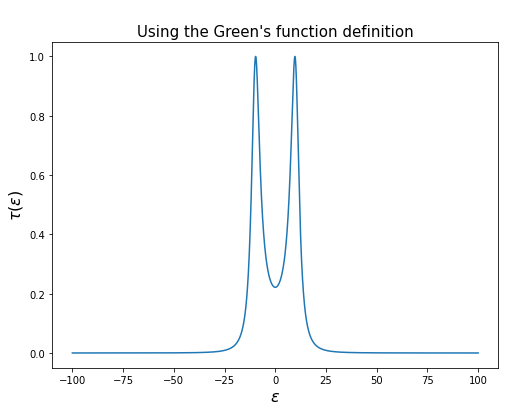

In [ ]:
et_axis = jnp.linspace(-100,100,50001)
my_tau_params = [0.01,
                 0.,
                 5.,
                 5.,
                 1.01,
                 1.0,
                 0.,
                 0.,
                 10] # (mu_L, mu_R, gamma_L, gamma_R, beta_L, beta_R, eps_L, eps_R, omega)
tau_out = v_tau(et_axis, my_tau_params) 
print(tau_out.shape)

fig, ax = plt.subplots(figsize=(8,6))

ax.plot(et_axis,tau_out)
ax.set_title("\nUsing the Green's function definition",fontsize=15)
ax.set_ylabel(r'$\tau (\epsilon)$',fontsize=16)
ax.set_xlabel(r'$\epsilon$',fontsize=16)
# plt.savefig("Serial_DD.png",dpi=500)
plt.show()